In [3]:
import warnings
warnings.filterwarnings("ignore")


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

spark=SparkSession.builder\
    .appName("Stock Data Analysis")\
    .config("spark.sql.legacy.timeParserPolicy","LEGACY")\
    .getOrCreate()

print(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/16 00:32:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/16 00:32:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/16 00:32:55 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/10/16 00:32:55 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/10/16 00:32:55 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [5]:
file_path = '/Users/sarabjotsingh/Desktop/Dataset/stocks_cleaned_file.csv/part-00000-6b5797e1-6f26-4de2-be41-0cb6a823dfb6-c000.csv'
df = spark.read.csv(file_path, header=True)
df.show(5)  


+--------------------+------------------+------------------+------------------+------------------+------+---------+------------+------+--------------------+------------------+------------------+
|                Date|              Open|              High|               Low|             Close|Volume|Dividends|Stock Splits|symbol|       Capital Gains|         Adj Close|Previous Day Close|
+--------------------+------------------+------------------+------------------+------------------+------+---------+------------+------+--------------------+------------------+------------------+
|2024-06-09T20:00:...|             26.25|             26.25|24.975000381469727|  25.1200008392334| 96778|      0.0|         0.0|  AAPX| -1.0099983215332031|  25.1200008392334|  26.1299991607666|
|2024-06-10T20:00:...|25.309999465942383|28.743000030517575|25.309999465942383|28.719999313354492|135347|      0.0|         0.0|  AAPX|  3.5999984741210938|28.719999313354492|  25.1200008392334|
|2024-06-11T20:00:...| 28

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

# Convert columns to DoubleType (numeric) before detecting outliers
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains', 'Adj Close', 'Previous Day Close']

# Ensure that numeric columns are cast to DoubleType
for column in numeric_columns:
    if column in df.columns:
        df = df.withColumn(column, F.col(column).cast(DoubleType()))



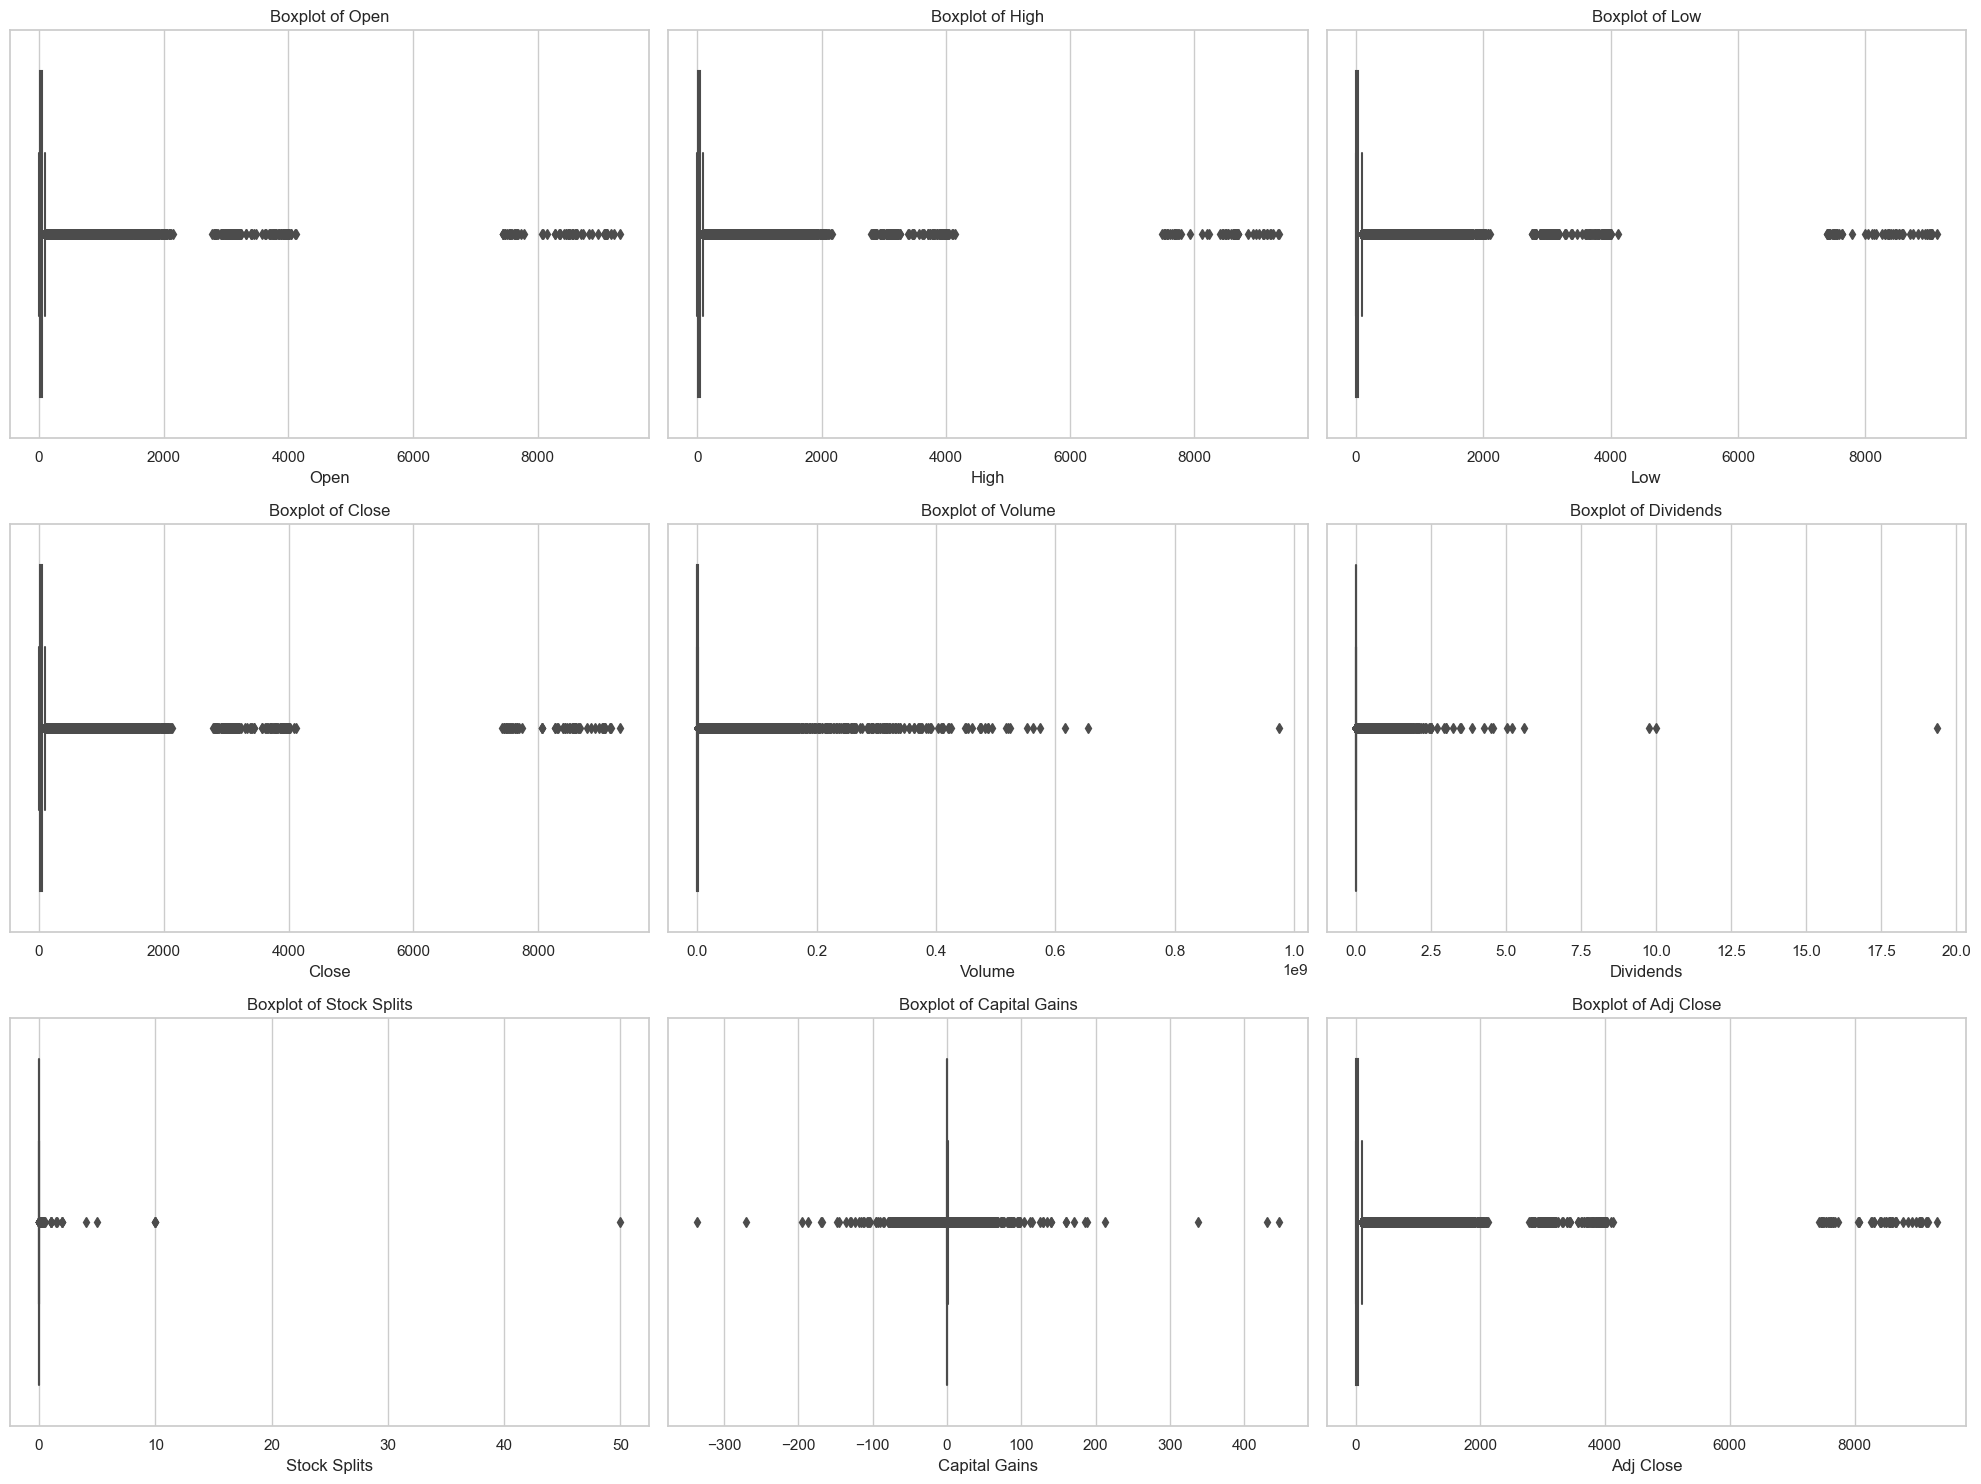

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Function to detect outliers using the IQR method in PySpark
def detect_outliers_pyspark(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the outliers from the DataFrame
    outliers_df = df.filter((F.col(column) < lower_bound) | (F.col(column) > upper_bound))
    return outliers_df

# List of numeric columns for outlier detection and visualization
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains', 'Adj Close']

# Detect outliers in each numeric column (this step processes the outliers but doesn't print them)
for column in numeric_columns:
    if column in df.columns:
        outliers = detect_outliers_pyspark(df, column)

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
df_pandas = df.select(numeric_columns).toPandas()

# Set the plot style
sns.set(style="whitegrid")

# Create subplots for the boxplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Generate a boxplot for each numeric column to visualize the outliers
for idx, column in enumerate(numeric_columns):
    sns.boxplot(data=df_pandas, x=column, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {column}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


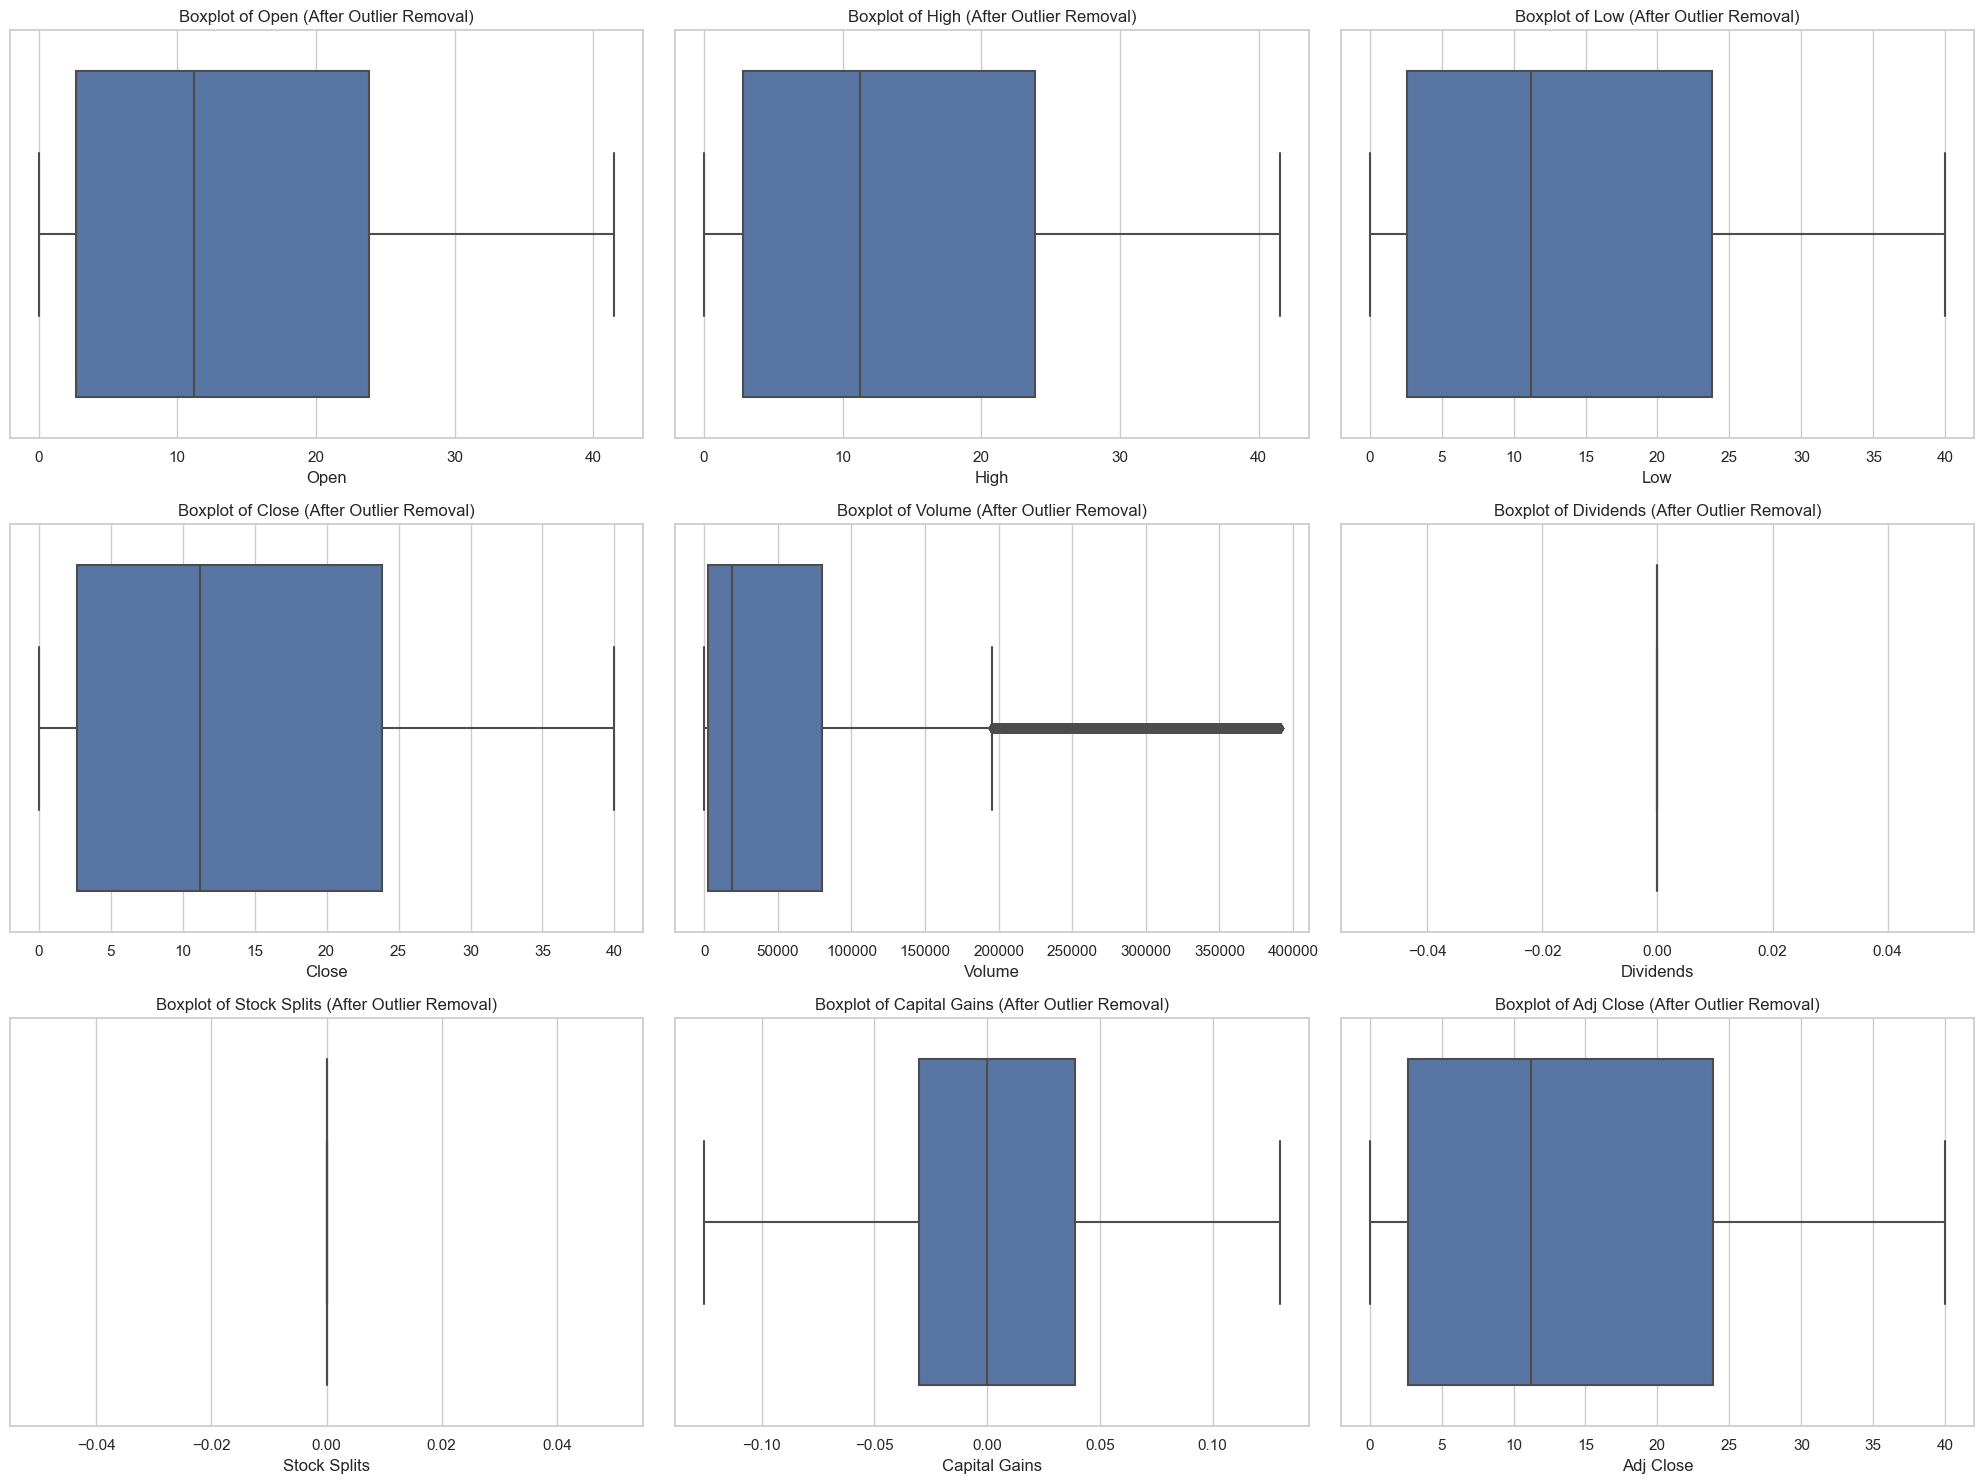

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Function to detect outliers using the IQR method in PySpark
def detect_and_remove_outliers_pyspark(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    quantiles = df.approxQuantile(column, [0.35, 0.65], 0.01)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame to remove outliers
    filtered_df = df.filter((F.col(column) >= lower_bound) & (F.col(column) <= upper_bound))
    return filtered_df

# List of numeric columns for outlier detection and visualization
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains', 'Adj Close']

# Start with the original DataFrame
cleaned_df = df

# Remove outliers from each numeric column
for column in numeric_columns:
    if column in cleaned_df.columns:
        cleaned_df = detect_and_remove_outliers_pyspark(cleaned_df, column)

# Convert the cleaned PySpark DataFrame to a Pandas DataFrame for visualization
df_pandas = cleaned_df.select(numeric_columns).toPandas()

# Set the plot style
sns.set(style="whitegrid")

# Create subplots for the boxplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Generate a boxplot for each numeric column to visualize the outliers
for idx, column in enumerate(numeric_columns):
    sns.boxplot(data=df_pandas, x=column, ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {column} (After Outlier Removal)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


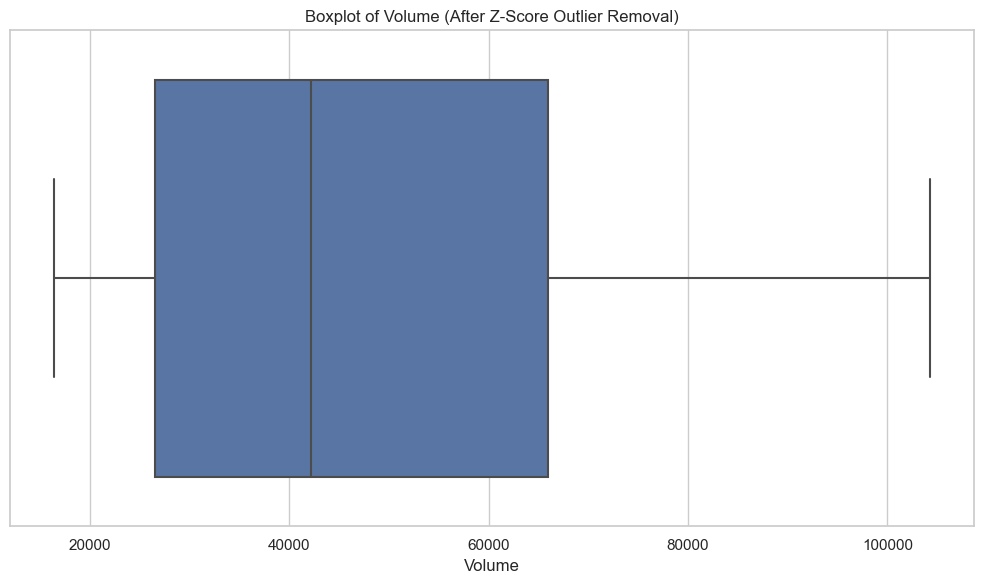

In [9]:
from pyspark.sql import functions as F

# Function to remove outliers using Z-Score
def remove_outliers_z_score(df, column, threshold=0.5):
    mean_value = df.select(F.mean(column)).first()[0]
    stddev_value = df.select(F.stddev(column)).first()[0]
    
    # Calculate Z-Score and filter based on threshold
    filtered_df = df.filter((F.col(column) <= mean_value + threshold * stddev_value) &
                            (F.col(column) >= mean_value - threshold * stddev_value))
    return filtered_df

# Remove outliers from the Volume column using Z-Score method
cleaned_df_z_score = remove_outliers_z_score(cleaned_df, 'Volume')

# Convert to Pandas DataFrame for visualization
df_pandas_z_score = cleaned_df_z_score.select(numeric_columns).toPandas()

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_pandas_z_score, x='Volume')
plt.title('Boxplot of Volume (After Z-Score Outlier Removal)')
plt.xlabel('Volume')
plt.tight_layout()
plt.show()


In [10]:
# Start with the original DataFrame
cleaned_df = df

# Remove outliers from each numeric column using IQR method
for column in numeric_columns:
    if column in cleaned_df.columns:
        cleaned_df = detect_and_remove_outliers_pyspark(cleaned_df, column)

# Remove outliers from the Volume column using Z-Score method
cleaned_df_z_score = remove_outliers_z_score(cleaned_df, 'Volume')

# Now, use cleaned_df_z_score for EDA
# You can store the final cleaned DataFrame under a single name, e.g., 'final_cleaned_df'
final_cleaned_df = cleaned_df_z_score

# Convert to Pandas DataFrame for further analysis
df_pandas_final = final_cleaned_df.select(numeric_columns).toPandas()


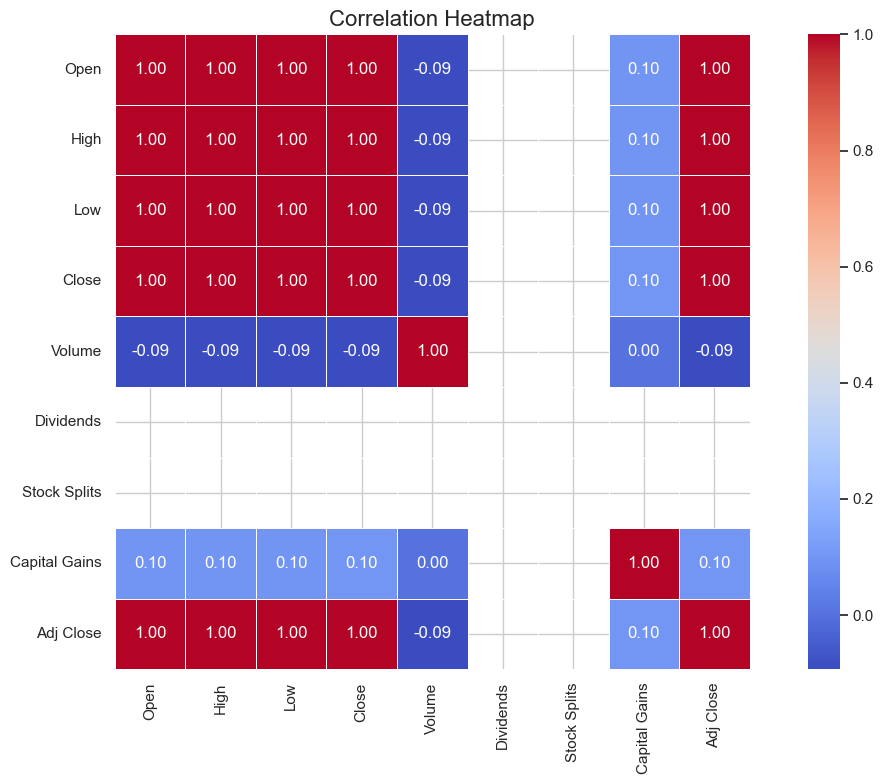

In [11]:
# Correlation matrix heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_pandas_final[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

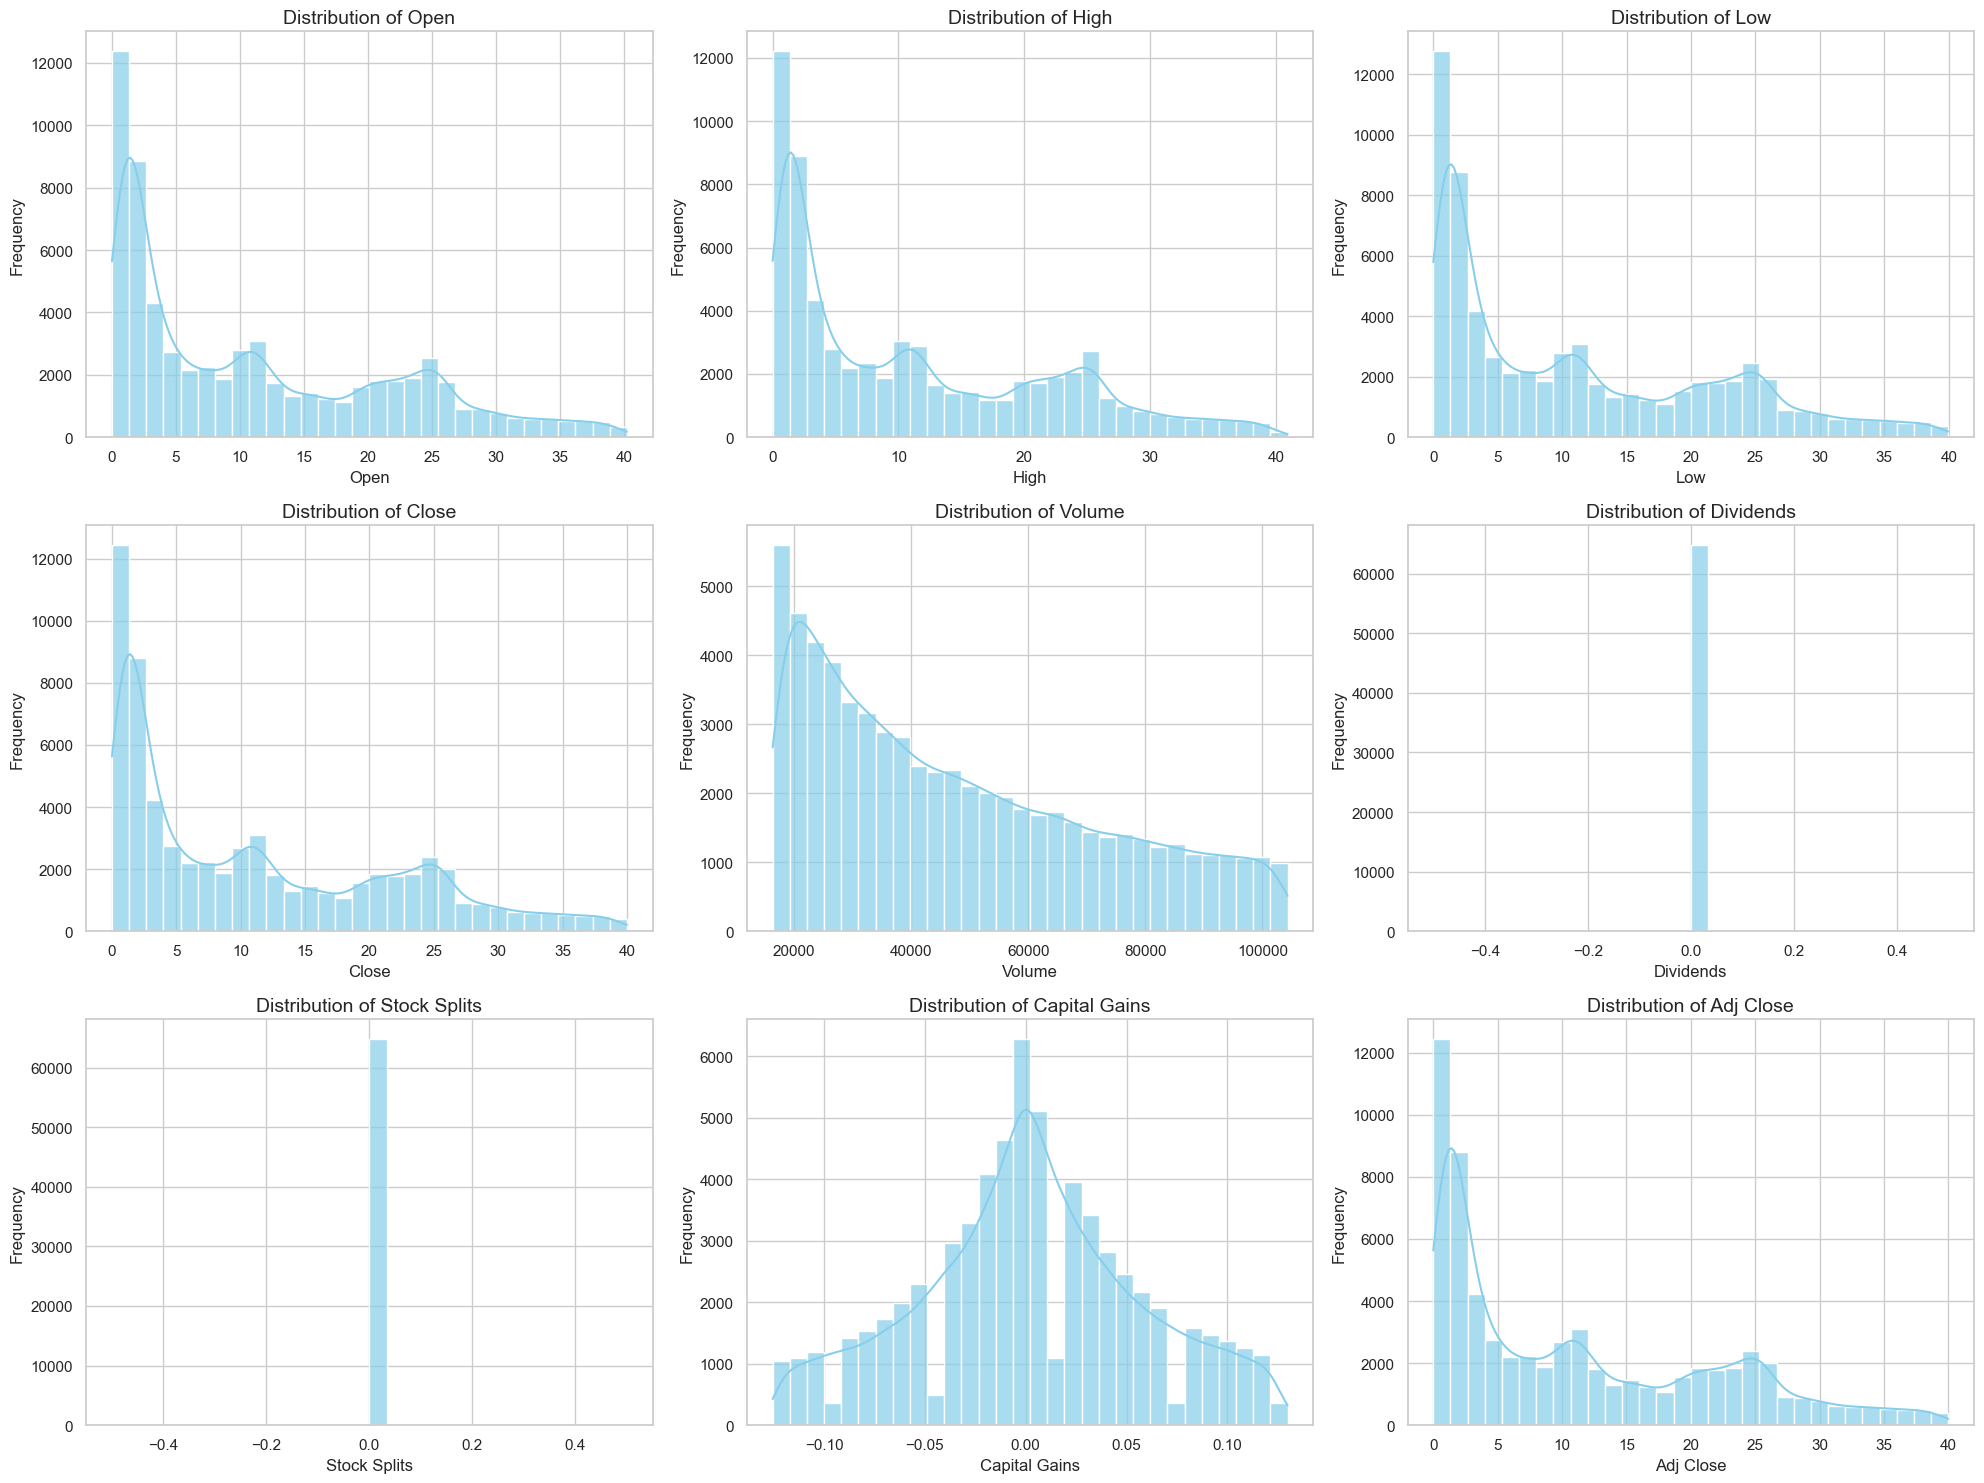

In [12]:
# Distribution of each numeric column
plt.figure(figsize=(20, 15))
for idx, column in enumerate(numeric_columns):
    plt.subplot(3, 3, idx + 1)
    sns.histplot(df_pandas_final[column], kde=True, bins=30, color='skyblue', alpha=0.7)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


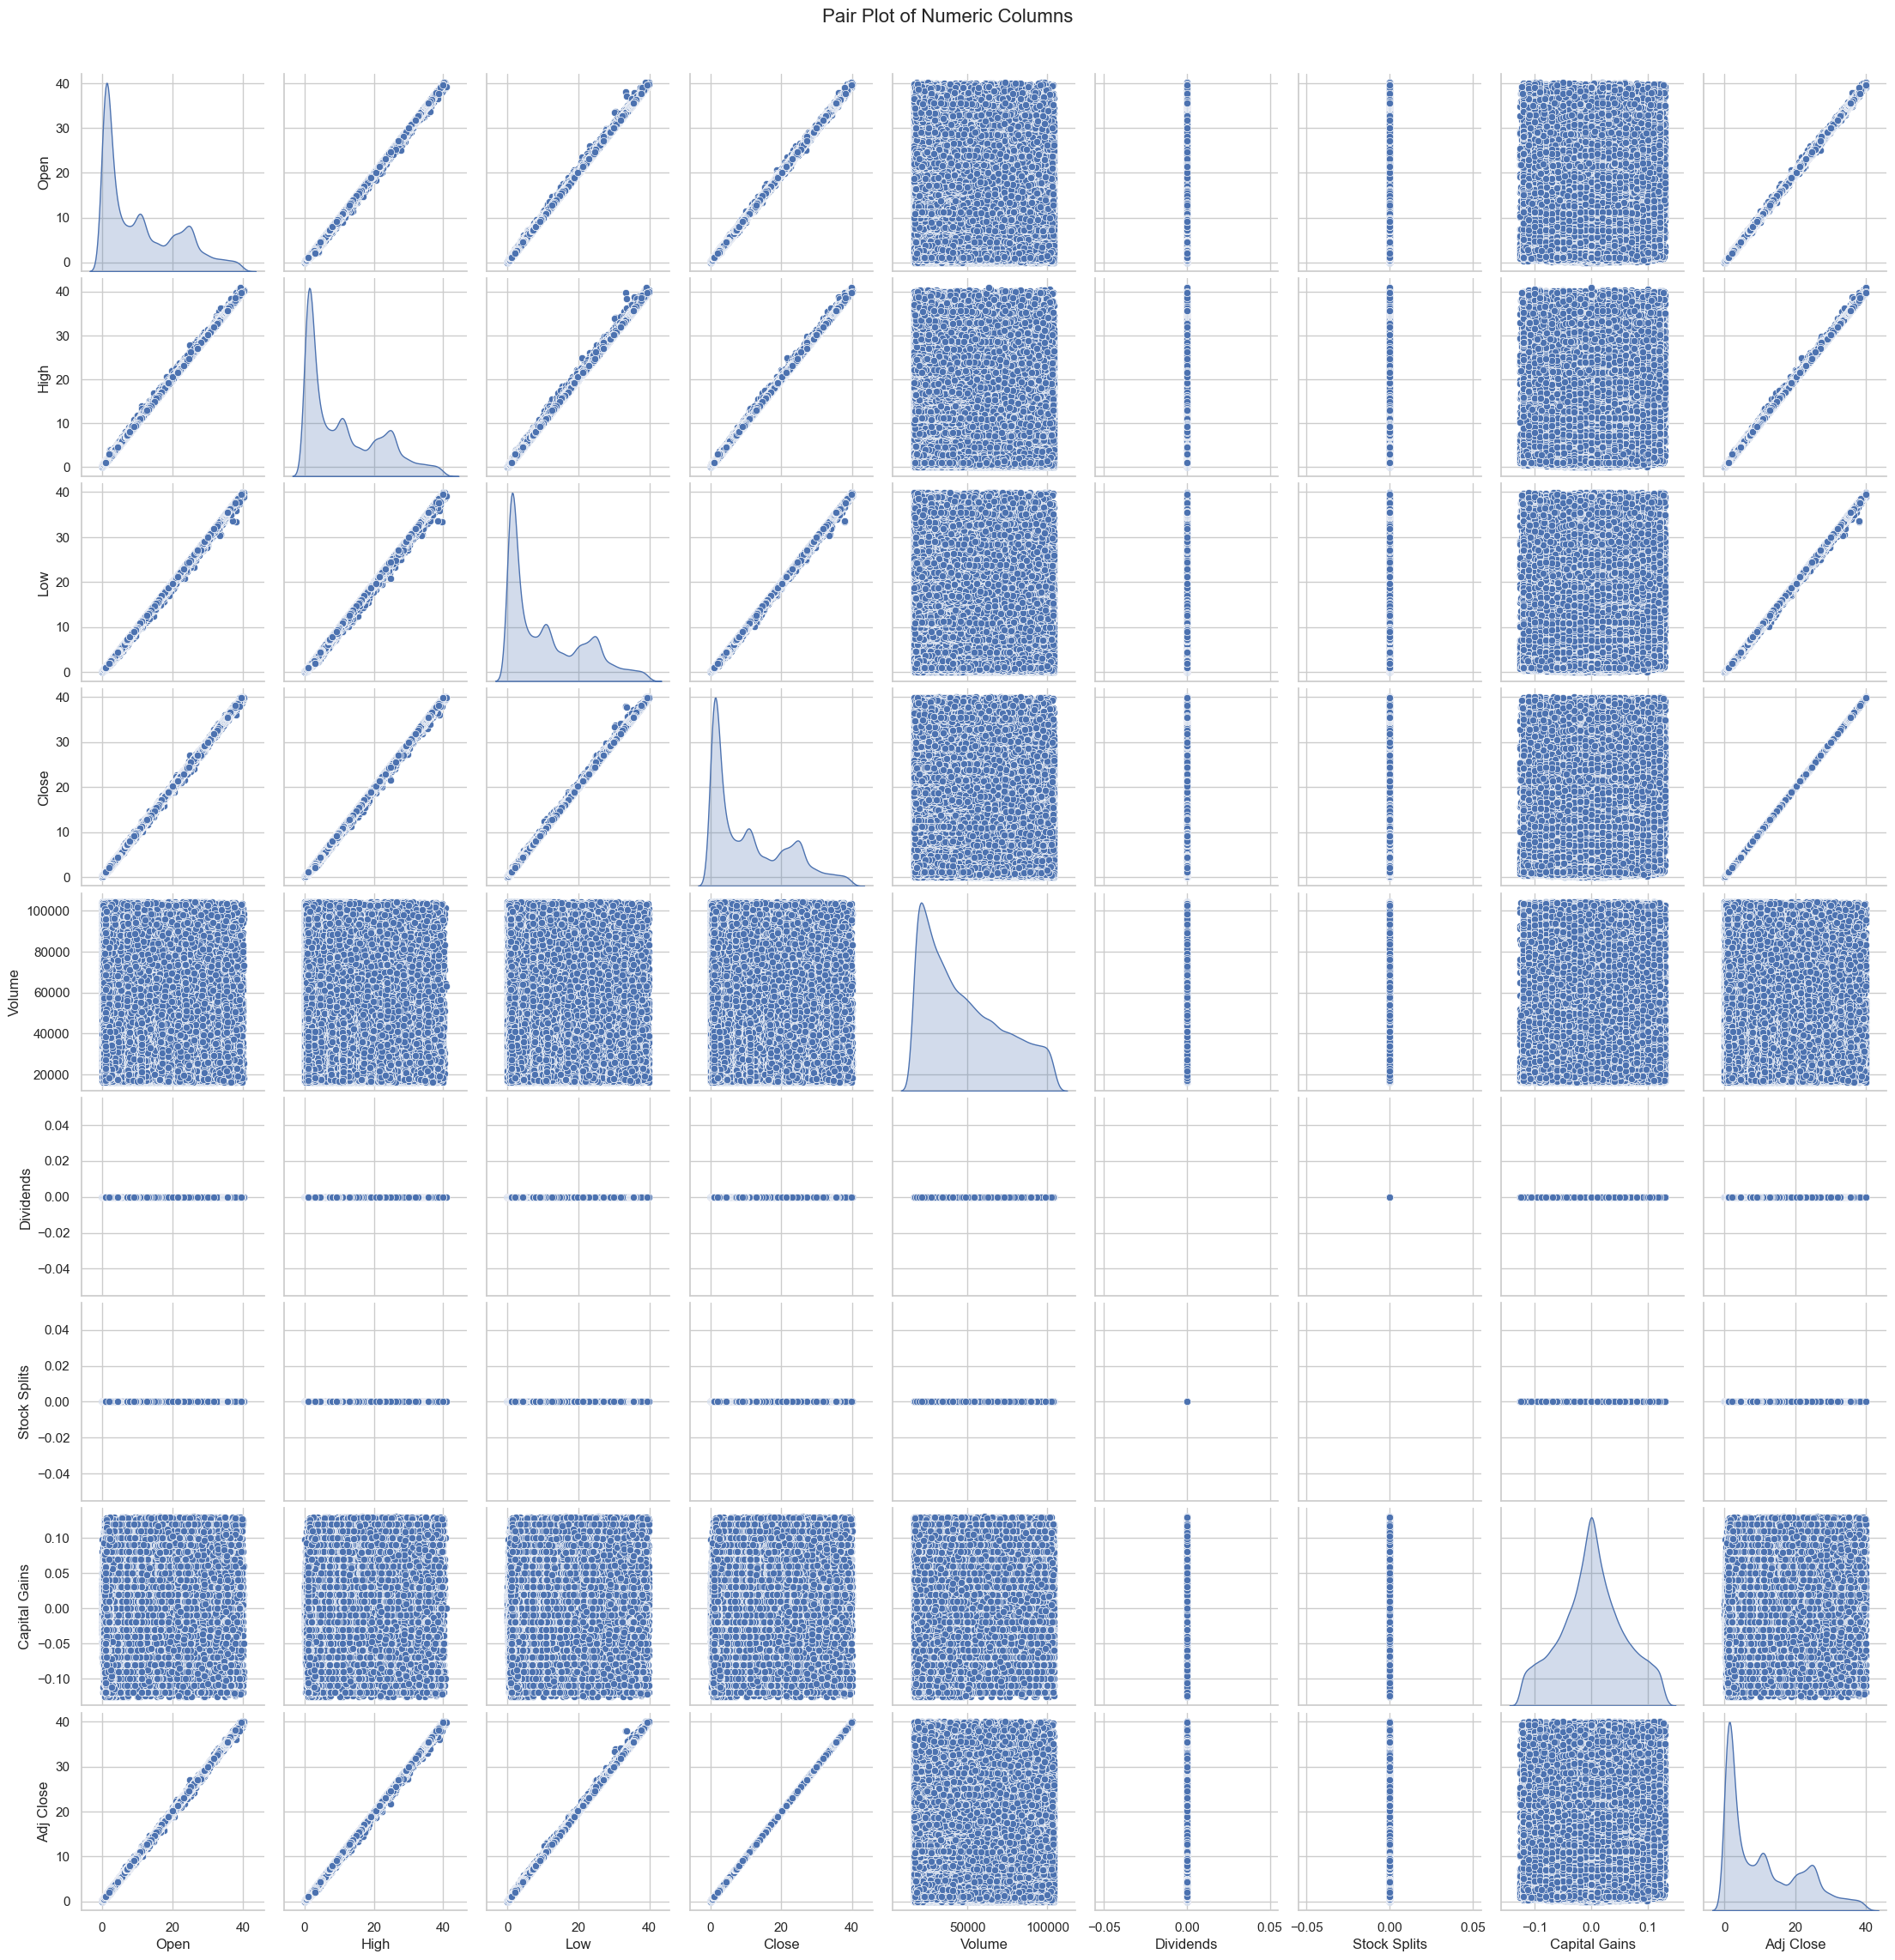

In [13]:
# Pair plot
sns.pairplot(df_pandas_final[numeric_columns], diag_kind='kde', palette='husl')
plt.suptitle('Pair Plot of Numeric Columns', y=1.02, fontsize=16)
plt.show()



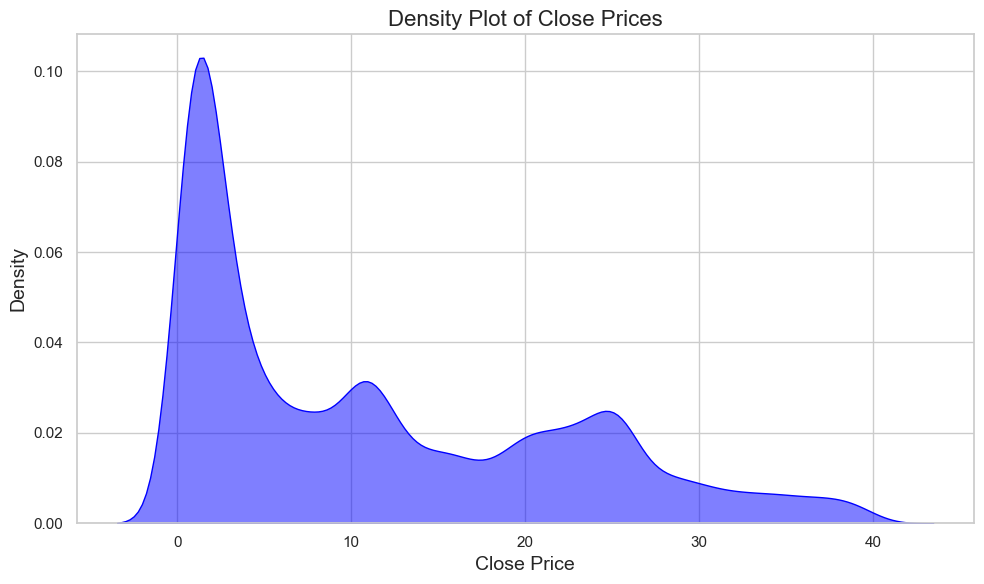

In [14]:
# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_pandas_final['Close'], shade=True, color='blue', alpha=0.5)
plt.title('Density Plot of Close Prices', fontsize=16)
plt.xlabel('Close Price', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.tight_layout()
plt.show()



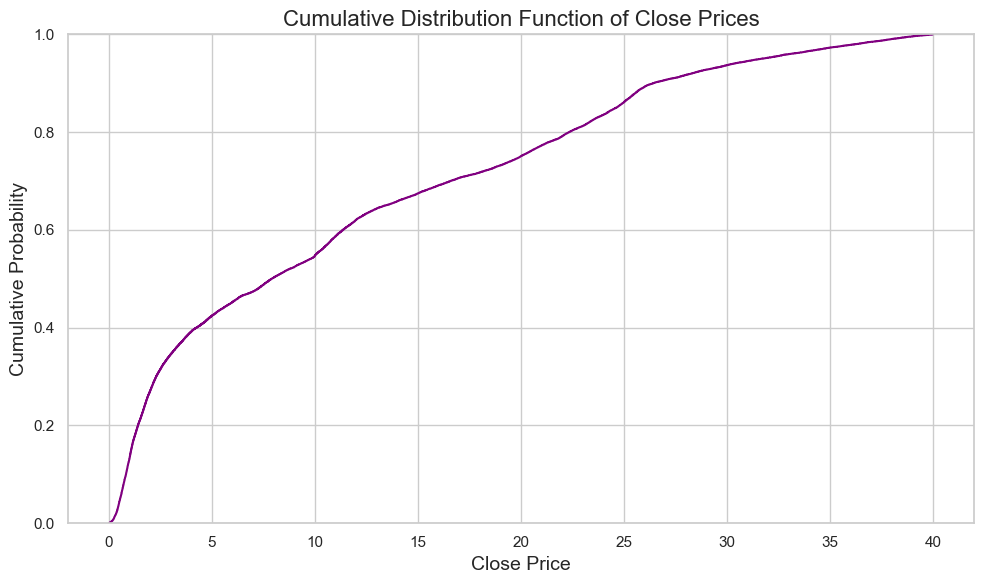

In [15]:
# Cumulative Distribution Function (CDF)
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df_pandas_final, x='Close', color='purple')
plt.title('Cumulative Distribution Function of Close Prices', fontsize=16)
plt.xlabel('Close Price', fontsize=14)
plt.ylabel('Cumulative Probability', fontsize=14)
plt.tight_layout()
plt.show()


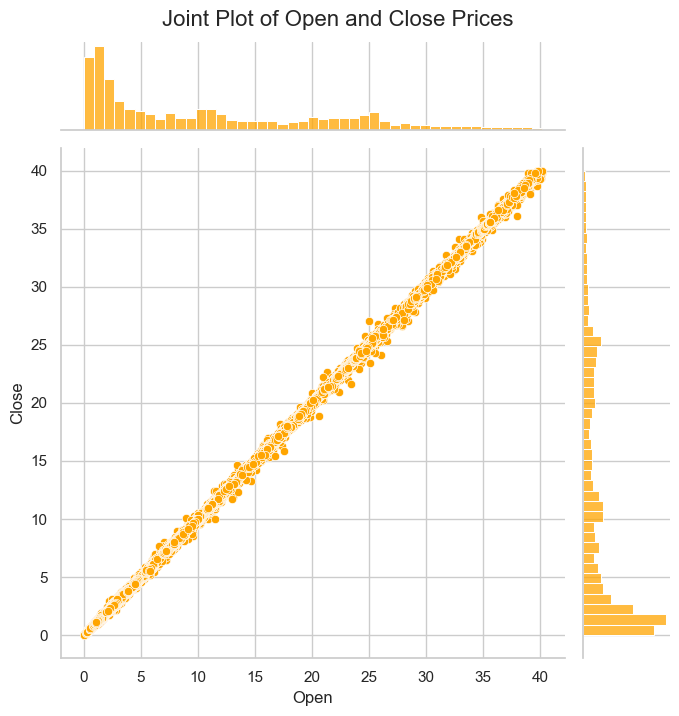

In [16]:
import seaborn as sns
sns.jointplot(data=df_pandas_final, x='Open', y='Close', kind='scatter', color='orange', height=7)
plt.suptitle('Joint Plot of Open and Close Prices', y=1.02, fontsize=16)
plt.show()